<a href="https://colab.research.google.com/github/mikekane007/Netflix-Streams-/blob/main/Netflix_Streams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'netflix-shows:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F434238%2F2654038%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T051515Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D90fe5fcc0bc1e0bdf8854250cb57a81cf61c7c1edf0b1399ec168520306d43c973ca90cdd04cdf625cf2a691cce5317b6cf32e78b3387e32801df1dda45c092eab0ff9deeeb6e7e410fd274c7f154ddefc93356ca877bae49b634bf828a64d9429344e656d982f0c7ab8707acfe385c360a3f9d7b61ae42624333f690f1753395e3ff117e5f06e1f018601e18cc416e791261836a3100d2b8d19b43b1d453ae25ebf67e651ac087394352b54a398f8cc1bdf684104681ad18036293da1653e94a8e46b030038c717725f0d64d7df6c544784e5a66d3e1f8d51bdc441e4f66df9f9d1530216e39695ba16f22832f88e63c9a4d27d9c772bdc59c912571b885f1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1400865 bytes downloaded
Downloaded and uncompressed: netflix-shows
Data source import complete.


# **1. Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', font_scale=1.2)
import matplotlib.pyplot as plt
import plotly.express as px

# **2. Exploring Data | Showing some Information**

In [ ]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

The dataset contains 8807 rows and 12 columns


In [ ]:
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [ ]:
df['rating'].value_counts().reset_index()

,rating,count
0,TV-MA,3207
1,TV-14,2160
2,TV-PG,863
3,R,799
4,PG-13,490
5,TV-Y7,334
6,TV-Y,307
7,PG,287
8,TV-G,220
9,NR,80


- **The last three entries (74 min, 84 min, 66 min) seem to be outliers in this context as they represent durations in minutes**

In [ ]:
df['duration'].value_counts().reset_index()

,duration,count
0,1 Season,1793
1,2 Seasons,425
2,3 Seasons,199
3,90 min,152
4,94 min,146
...,...,...
215,16 min,1
216,186 min,1
217,193 min,1
218,189 min,1


In [ ]:
# edit the date_added column
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce', infer_datetime_format=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       7976 non-null   object        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8803 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 825.8+ KB


In [ ]:
directors = df['director'].value_counts().reset_index()
directors

,director,count
0,Rajiv Chilaka,19
1,"Raúl Campos, Jan Suter",18
2,Marcus Raboy,16
3,Suhas Kadav,16
4,Jay Karas,14
...,...,...
4523,"Raymie Muzquiz, Stu Livingston",1
4524,Joe Menendez,1
4525,Eric Bross,1
4526,Will Eisenberg,1


In [ ]:
directors = df.groupby(['director', 'type'])['director'].value_counts().reset_index()
directors

,director,type,count
0,A. L. Vijay,Movie,2
1,A. Raajdheep,Movie,1
2,A. Salaam,Movie,1
3,A.R. Murugadoss,Movie,2
4,Aadish Keluskar,Movie,1
...,...,...,...
4571,Çagan Irmak,Movie,1
4572,Ísold Uggadóttir,Movie,1
4573,Óskar Thór Axelsson,Movie,1
4574,Ömer Faruk Sorak,Movie,2


In [ ]:
top_10_directors = df.groupby(['director', 'type'])['director'].value_counts().sort_values(ascending=False).iloc[2:12]
top_10_directors

director             type 
Suhas Kadav          Movie    16
Marcus Raboy         Movie    15
Jay Karas            Movie    14
Cathy Garcia-Molina  Movie    13
Jay Chapman          Movie    12
Youssef Chahine      Movie    12
Martin Scorsese      Movie    12
Steven Spielberg     Movie    11
Don Michael Paul     Movie    10
David Dhawan         Movie     9
Name: count, dtype: int64

In [ ]:
countries = df.groupby(['country', 'type'])['country'].value_counts().reset_index()
countries

,country,type,count
0,", France, Algeria",Movie,1
1,", South Korea",TV Show,1
2,Argentina,Movie,38
3,Argentina,TV Show,18
4,"Argentina, Brazil, France, Poland, Germany, De...",Movie,1
...,...,...,...
842,Venezuela,Movie,1
843,"Venezuela, Colombia",Movie,1
844,Vietnam,Movie,7
845,West Germany,Movie,1


In [ ]:
top_10_countries = df.groupby(['country', 'type'])['country'].value_counts().sort_values(ascending = False).iloc[0:10]
top_10_countries

country         type   
United States   Movie      2058
India           Movie       893
United States   TV Show     760
United Kingdom  TV Show     213
                Movie       206
Japan           TV Show     169
South Korea     TV Show     158
Canada          Movie       122
Spain           Movie        97
Egypt           Movie        92
Name: count, dtype: int64

In [ ]:
release_years = df.groupby(['release_year', 'type'])['release_year'].value_counts().reset_index()
release_years

,release_year,type,count
0,1925,TV Show,1
1,1942,Movie,2
2,1943,Movie,3
3,1944,Movie,3
4,1945,Movie,3
...,...,...,...
114,2019,TV Show,397
115,2020,Movie,517
116,2020,TV Show,436
117,2021,Movie,277


In [ ]:
top_10_movies_years = release_years[release_years['type'] == 'Movie'].sort_values(by= 'count', ascending=False).iloc[0:10]
top_10_movies_years

,release_year,type,count
111,2018,Movie,767
109,2017,Movie,767
107,2016,Movie,658
113,2019,Movie,633
115,2020,Movie,517
105,2015,Movie,398
117,2021,Movie,277
103,2014,Movie,264
101,2013,Movie,225
99,2012,Movie,173


In [ ]:
ratings = df.groupby(['rating', 'type'])['type'].value_counts().reset_index()
ratings

,rating,type,count
0,66 min,Movie,1
1,74 min,Movie,1
2,84 min,Movie,1
3,G,Movie,41
4,NC-17,Movie,3
5,NR,Movie,75
6,NR,TV Show,5
7,PG,Movie,287
8,PG-13,Movie,490
9,R,Movie,797


In [ ]:
top_10_movies_ratings = ratings[ratings['type'] == 'Movie'].sort_values(by= 'count',ascending=False).iloc[0:10]
top_10_movies_ratings

,rating,type,count
15,TV-MA,Movie,2062
11,TV-14,Movie,1427
9,R,Movie,797
17,TV-PG,Movie,540
8,PG-13,Movie,490
7,PG,Movie,287
21,TV-Y7,Movie,139
19,TV-Y,Movie,131
13,TV-G,Movie,126
5,NR,Movie,75


In [ ]:
top_10_TV_Show_ratings = ratings[ratings['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_TV_Show_ratings

,rating,type,count
16,TV-MA,TV Show,1145
12,TV-14,TV Show,733
18,TV-PG,TV Show,323
22,TV-Y7,TV Show,195
20,TV-Y,TV Show,176
14,TV-G,TV Show,94
6,NR,TV Show,5
10,R,TV Show,2
24,TV-Y7-FV,TV Show,1


In [ ]:
durations = df.groupby(['duration','type'])['duration'].value_counts().reset_index()
durations

,duration,type,count
0,1 Season,TV Show,1793
1,10 Seasons,TV Show,7
2,10 min,Movie,1
3,100 min,Movie,108
4,101 min,Movie,116
...,...,...,...
215,95 min,Movie,137
216,96 min,Movie,130
217,97 min,Movie,146
218,98 min,Movie,120


In [ ]:
top_10_movie_durations = durations[durations['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_movie_durations

,duration,type,count
210,90 min,Movie,152
213,93 min,Movie,146
214,94 min,Movie,146
217,97 min,Movie,146
211,91 min,Movie,144
215,95 min,Movie,137
216,96 min,Movie,130
212,92 min,Movie,129
5,102 min,Movie,122
218,98 min,Movie,120


In [ ]:
top_10_TV_Show_durations = durations[durations['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_TV_Show_durations

,duration,type,count
0,1 Season,TV Show,1793
110,2 Seasons,TV Show,425
138,3 Seasons,TV Show,199
151,4 Seasons,TV Show,95
162,5 Seasons,TV Show,65
174,6 Seasons,TV Show,33
185,7 Seasons,TV Show,23
196,8 Seasons,TV Show,17
208,9 Seasons,TV Show,9
1,10 Seasons,TV Show,7


In [ ]:
listed_in = df.groupby(['listed_in', 'type'])['listed_in'].value_counts().reset_index()
listed_in

,listed_in,type,count
0,Action & Adventure,Movie,128
1,"Action & Adventure, Anime Features",Movie,1
2,"Action & Adventure, Anime Features, Children &...",Movie,4
3,"Action & Adventure, Anime Features, Classic Mo...",Movie,2
4,"Action & Adventure, Anime Features, Horror Movies",Movie,1
...,...,...,...
509,"TV Horror, TV Mysteries, Teen TV Shows",TV Show,1
510,"TV Horror, Teen TV Shows",TV Show,2
511,"TV Sci-Fi & Fantasy, TV Thrillers",TV Show,1
512,TV Shows,TV Show,16


In [ ]:
top_10_listed_in_movie = listed_in[listed_in['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_listed_in_movie

,listed_in,type,count
326,"Dramas, International Movies",Movie,362
274,Documentaries,Movie,359
470,Stand-Up Comedy,Movie,334
200,"Comedies, Dramas, International Movies",Movie,274
319,"Dramas, Independent Movies, International Movies",Movie,252
121,Children & Family Movies,Movie,215
125,"Children & Family Movies, Comedies",Movie,201
281,"Documentaries, International Movies",Movie,186
329,"Dramas, International Movies, Romantic Movies",Movie,180
217,"Comedies, International Movies",Movie,176


In [ ]:
top_10_listed_in_TV_Show = listed_in[listed_in['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_listed_in_TV_Show

,listed_in,type,count
422,Kids' TV,TV Show,220
412,"International TV Shows, TV Dramas",TV Show,121
244,"Crime TV Shows, International TV Shows, TV Dramas",TV Show,110
433,"Kids' TV, TV Comedies",TV Show,99
446,Reality TV,TV Show,95
393,"International TV Shows, Romantic TV Shows, TV ...",TV Show,94
394,"International TV Shows, Romantic TV Shows, TV ...",TV Show,90
80,"Anime Series, International TV Shows",TV Show,88
291,Docuseries,TV Show,85
487,TV Comedies,TV Show,69


# **3. Duplicated | Nulls**

In [ ]:
df.duplicated().any()

False

In [ ]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        98
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

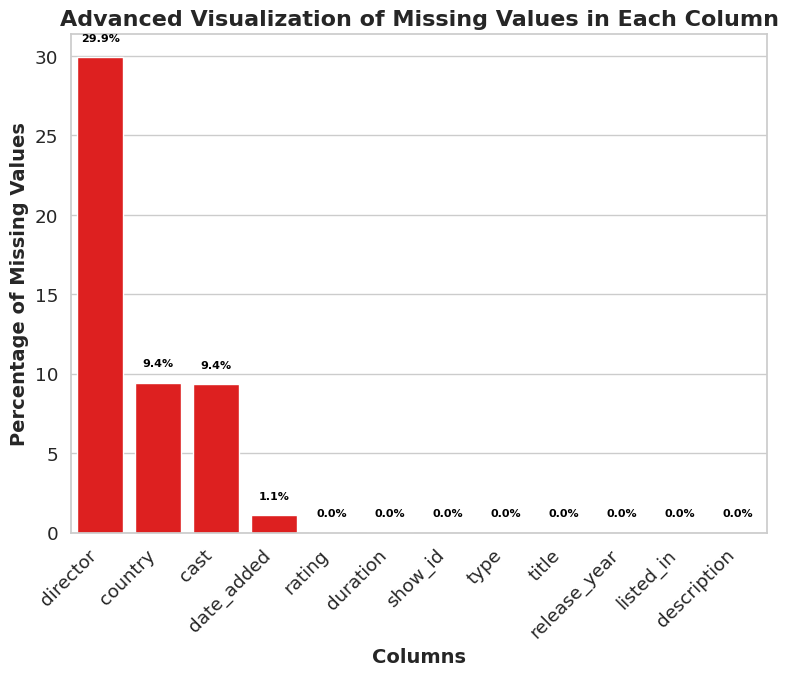

In [ ]:
plt.figure(figsize=(8, 7))

# Plot the null values by their percentage in each column
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

color = ["#fd0000"]
gradient = np.linspace(0, 1, len(missing_percentage_sorted))
colors = sns.color_palette(color, len(missing_percentage_sorted)).as_hex()

barplot = sns.barplot(x=missing_percentage_sorted.index, y=missing_percentage_sorted, palette=colors)

for index, value in enumerate(missing_percentage_sorted):
    barplot.text(index, value + 1, f'{value:.1f}%', ha='center', color='black', fontsize=8, weight='bold')

plt.xlabel('Columns', fontsize=14, weight='bold')
plt.ylabel('Percentage of Missing Values', fontsize=14, weight='bold')
plt.title('Advanced Visualization of Missing Values in Each Column', fontsize=16, weight='bold')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# **4. Visualization**

# **4.1 Univariate Analysis**

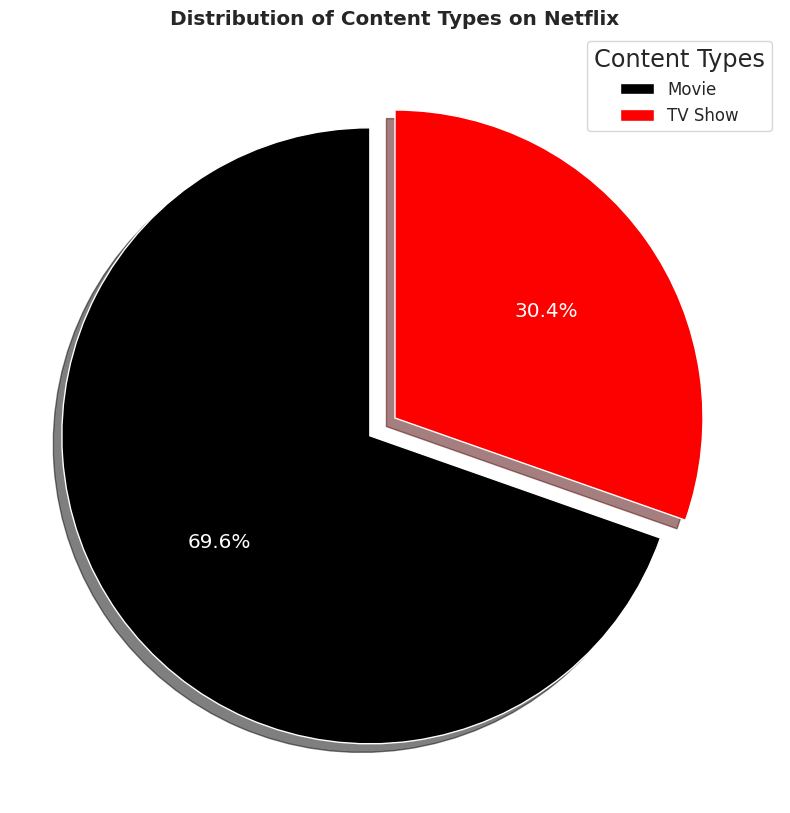

In [ ]:
type_counts = df['type'].value_counts()

colors = ['#000000', '#fd0000']

# Explode the first slice
explode = [0.1] + [0] * (len(type_counts) - 1)

plt.figure(figsize=(14,10))
plt.pie(type_counts, labels=type_counts.index, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True, textprops={'color': 'white'})
plt.title('Distribution of Content Types on Netflix', weight='bold')

legend = plt.legend(type_counts.index, title="Content Types", loc="upper right", fontsize='small')
legend.set_title("Content Types", prop={'size': 'large'})

plt.show()

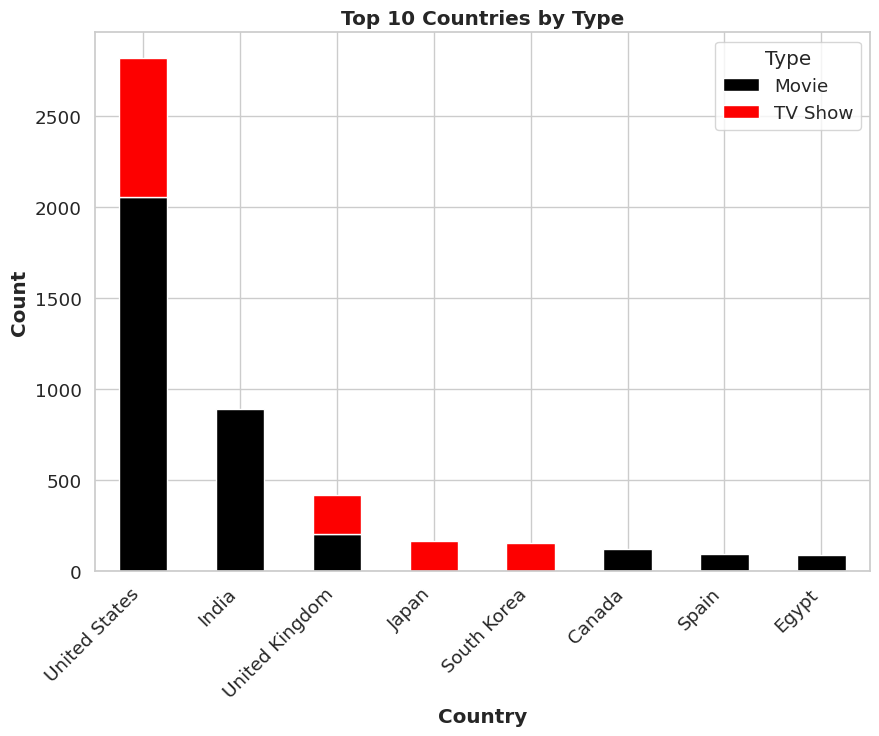

In [ ]:
top_10_df = top_10_countries.unstack(level='type')

colors = ['#000000', '#fd0000']
ax = top_10_df.plot(kind='bar', stacked=True, color=colors, figsize=(10, 7))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_xlabel('Country', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Top 10 Countries by Type', fontweight='bold')

ax.legend(title='Type', loc='upper right')

plt.show()

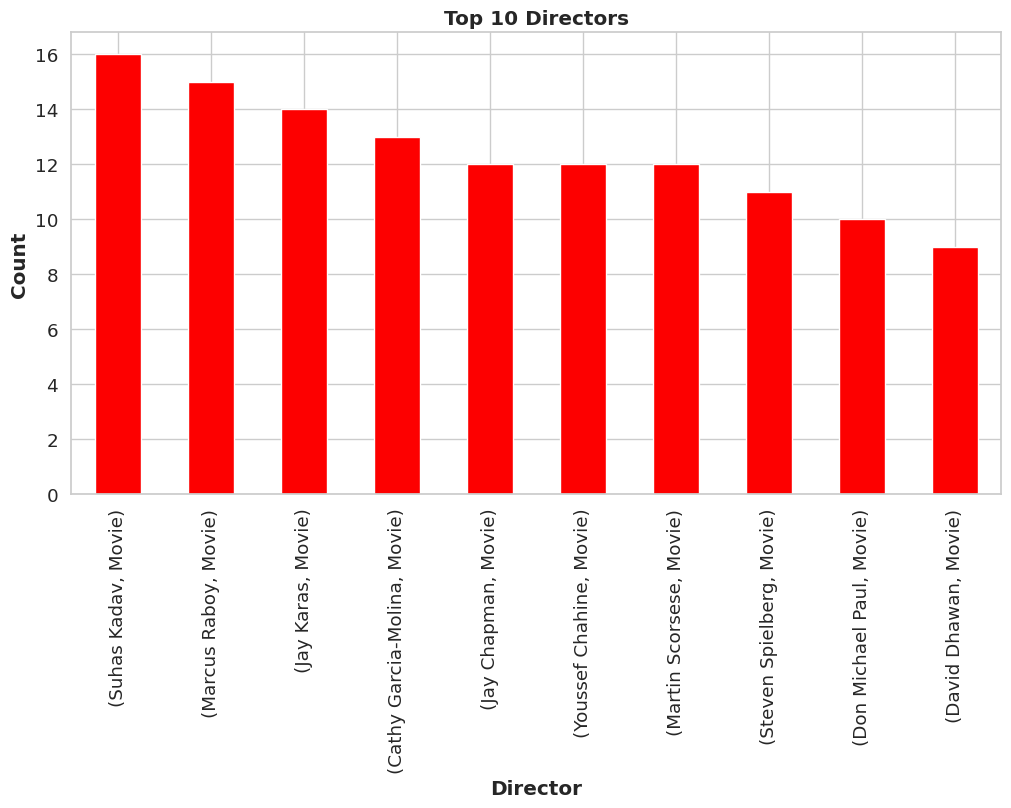

In [ ]:
plt.figure(figsize=(12, 6))
top_10_directors.plot(x='director', y='count', kind='bar',color='#fd0000')
plt.title('Top 10 Directors',fontweight='bold')
plt.xlabel('Director',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

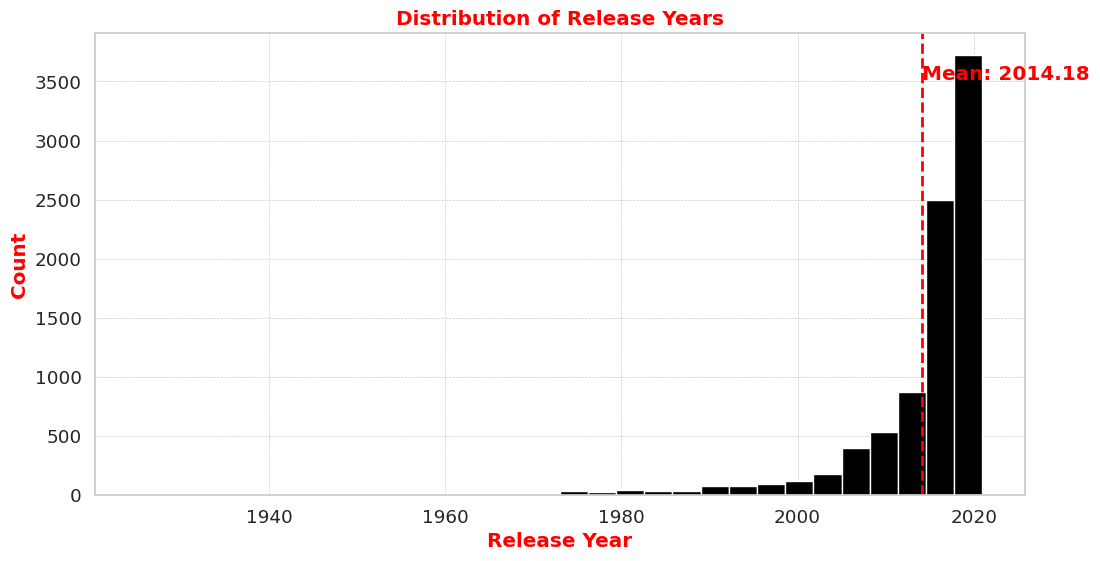

In [ ]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['release_year'], bins=30, color='black')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

mean_value = df['release_year'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', weight='bold')

plt.title('Distribution of Release Years', weight='bold',color='red')
plt.xlabel('Release Year', weight='bold',color='red')
plt.ylabel('Count', weight='bold',color='red')

plt.show()

In [ ]:
# Create a new column 'added_year' to store the year part of 'date_added'
df['added_year'] = df['date_added'].dt.year
added_per_year = df['added_year'].value_counts().sort_index()

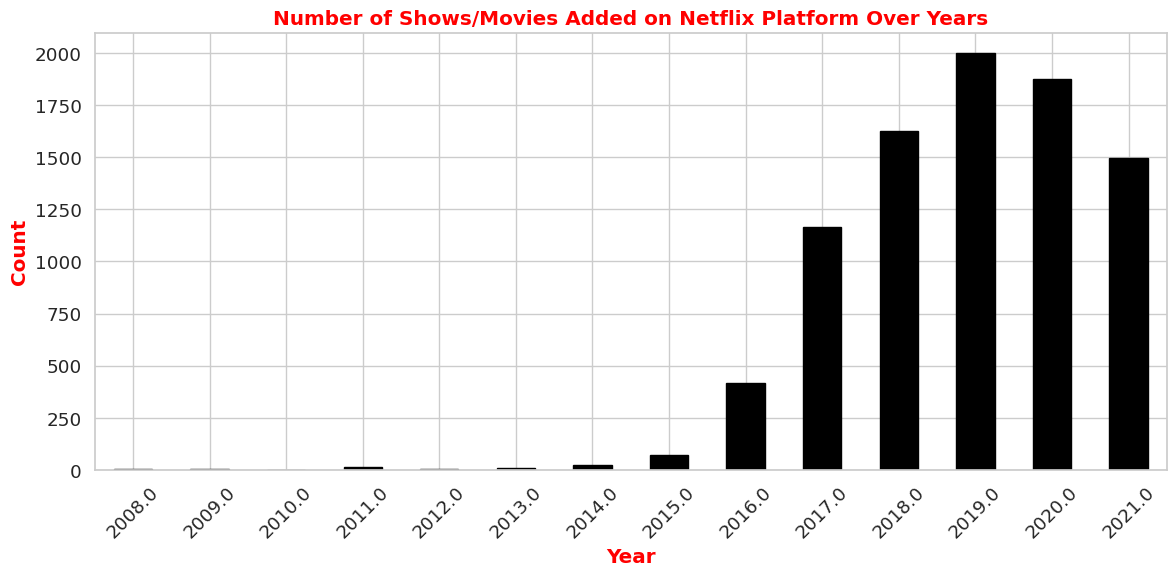

In [ ]:
plt.figure(figsize=(12, 6))
added_per_year.plot(kind='bar', color='#000000', edgecolor='black')
plt.title('Number of Shows/Movies Added on Netflix Platform Over Years',weight='bold',color='red')
plt.xlabel('Year',weight='bold',color='red')
plt.ylabel('Count',weight='bold',color='red')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **4.2 Bivariate Analysis**

<Figure size 1400x800 with 0 Axes>

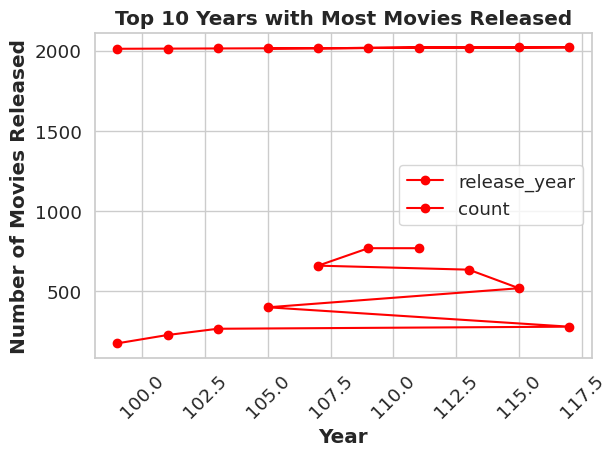

In [ ]:
plt.figure(figsize=(14, 8))
top_10_movies_years.plot( marker='o', color='red', label='Number of Movies')
plt.xlabel('Year', weight='bold')
plt.ylabel('Number of Movies Released', weight='bold')
plt.title('Top 10 Years with Most Movies Released', weight='bold')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

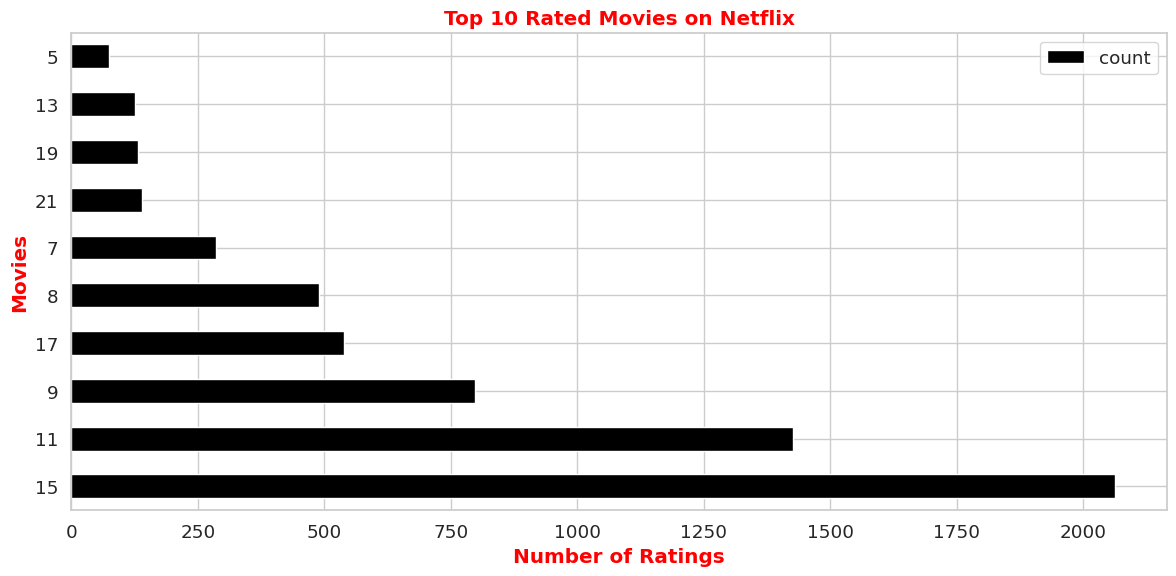

In [ ]:
top_10_movies_ratings = top_10_movies_ratings.sort_values(by='count', ascending=False)

top_10_movies_ratings.plot(kind='barh', color='#000000',figsize=(12,6))

plt.title('Top 10 Rated Movies on Netflix',weight='bold',color='red')
plt.xlabel('Number of Ratings',weight='bold',color='red')
plt.ylabel('Movies',weight='bold',color='red')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

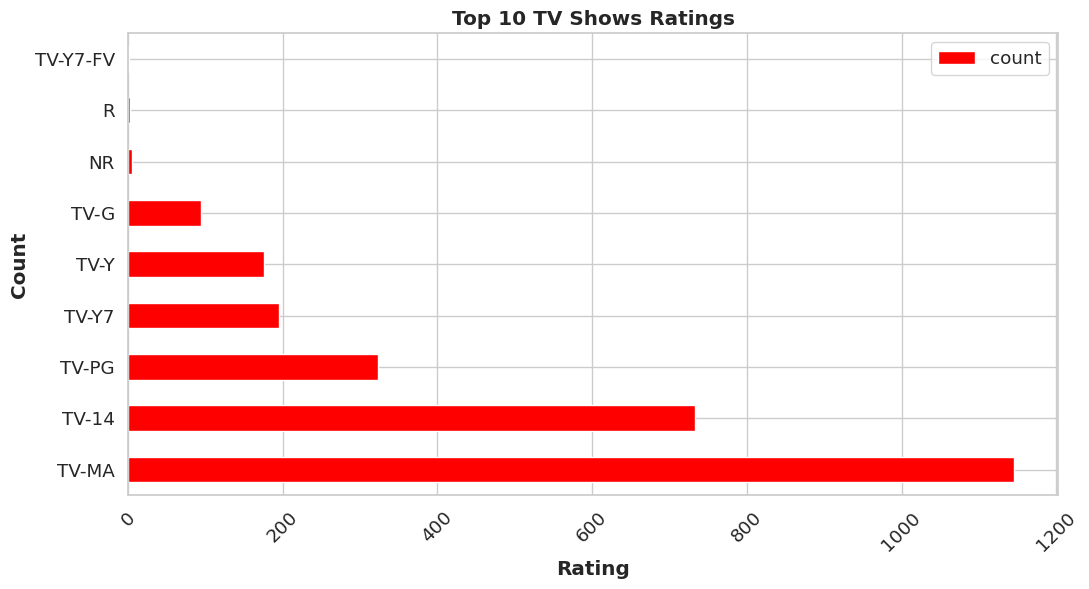

In [ ]:
top_10_TV_Show_ratings.plot(x='rating', y='count', kind='barh',figsize=(12,6),color='red')

plt.title('Top 10 TV Shows Ratings',weight='bold')
plt.xlabel('Rating',weight='bold')
plt.ylabel('Count',weight='bold')
plt.xticks(rotation=45)
ax.legend(loc='upper right')

plt.show()

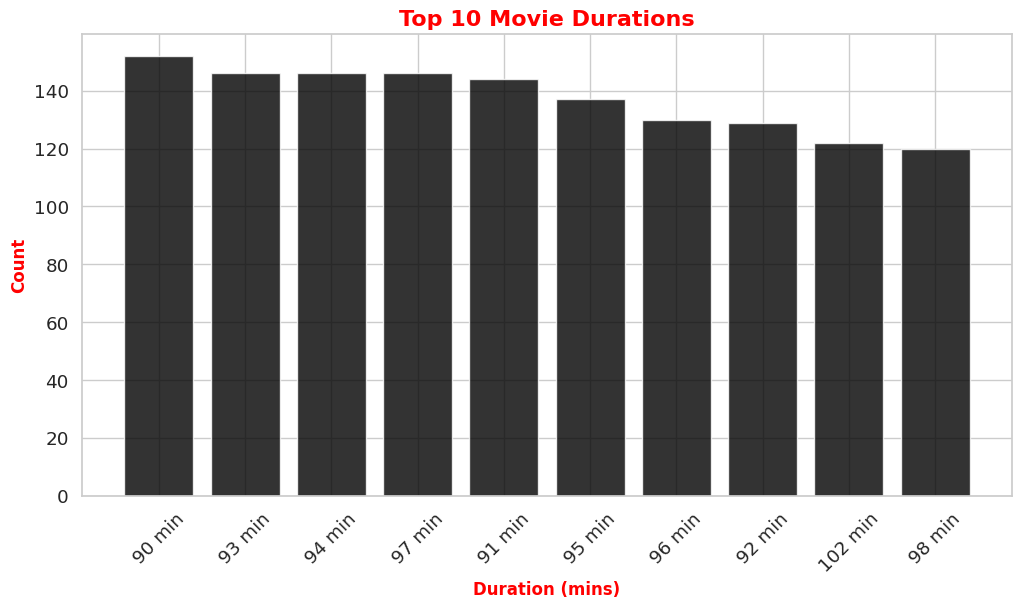

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(top_10_movie_durations['duration'], top_10_movie_durations['count'],
       color='#000000', alpha=0.8)

ax.set_title('Top 10 Movie Durations', fontsize=16,weight='bold',color='red')
ax.set_xlabel('Duration (mins)', fontsize=12,weight='bold',color='red')
ax.set_ylabel('Count', fontsize=12,weight='bold',color='red')
ax.tick_params(axis='x', rotation=45)

plt.show()

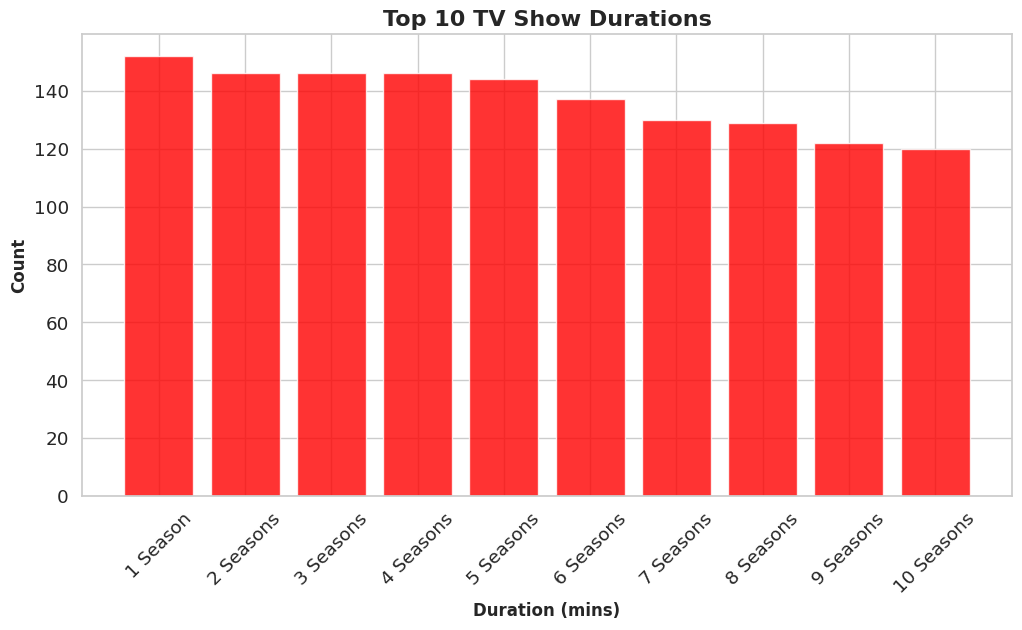

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(top_10_TV_Show_durations['duration'], top_10_movie_durations['count'],
       color='red', alpha=0.8)

ax.set_title('Top 10 TV Show Durations', fontsize=16,weight='bold')
ax.set_xlabel('Duration (mins)', fontsize=12,weight='bold')
ax.set_ylabel('Count', fontsize=12,weight='bold')
ax.tick_params(axis='x', rotation=45)

plt.show()


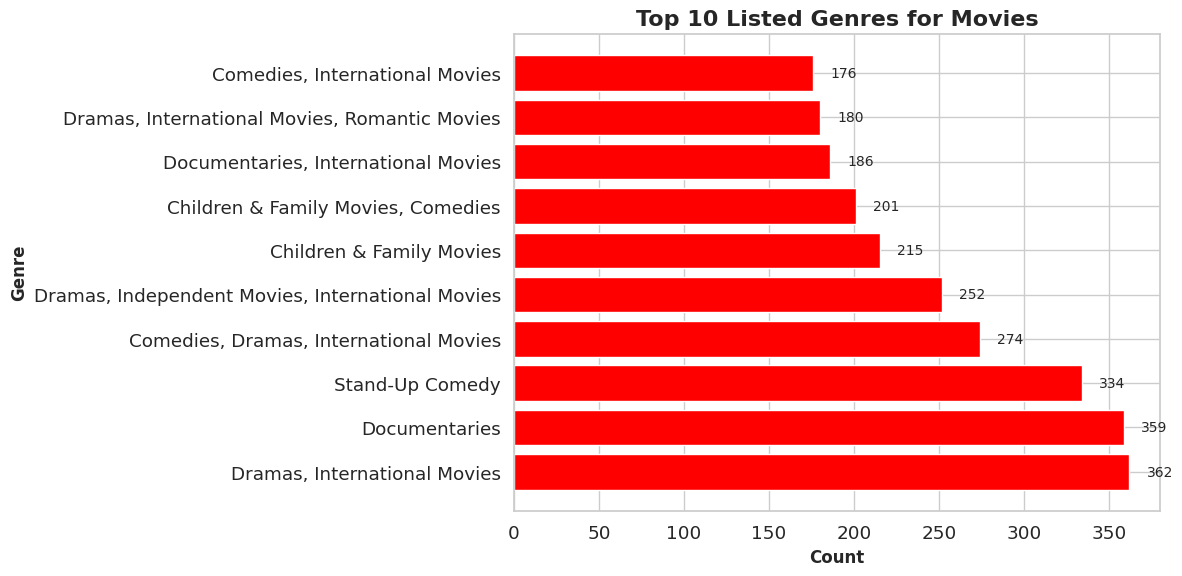

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['red']

ax.barh(top_10_listed_in_movie['listed_in'], top_10_listed_in_movie['count'], color=colors)

ax.set_title('Top 10 Listed Genres for Movies', fontsize=16,weight='bold')
ax.set_xlabel('Count', fontsize=12,weight='bold')
ax.set_ylabel('Genre', fontsize=12,weight='bold')
ax.tick_params(axis='y', rotation=0)

# Add data labels to the bars
for i, count in enumerate(top_10_listed_in_movie['count']):
    ax.text(count + 10, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

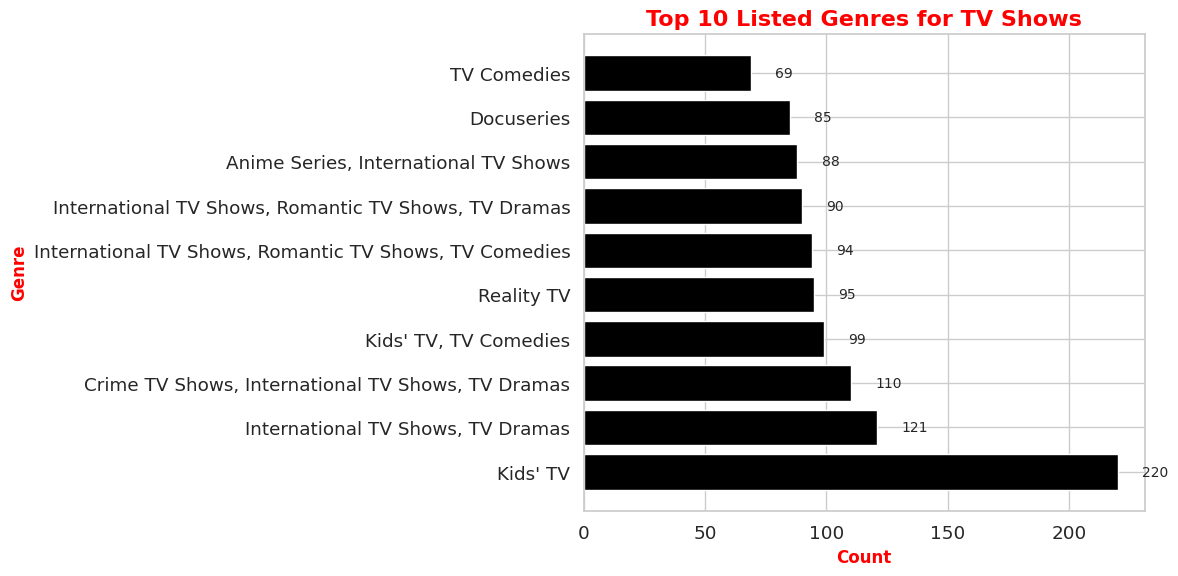

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['black']

ax.barh(top_10_listed_in_TV_Show['listed_in'], top_10_listed_in_TV_Show['count'], color=colors)

ax.set_title('Top 10 Listed Genres for TV Shows', fontsize=16,weight='bold',color='red')
ax.set_xlabel('Count', fontsize=12,weight='bold',color='red')
ax.set_ylabel('Genre', fontsize=12,weight='bold',color='red')
ax.tick_params(axis='y', rotation=0)

# Add data labels to the bars
for i, count in enumerate(top_10_listed_in_TV_Show['count']):
    ax.text(count + 10, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()